fetal_health
2.0    1655
1.0    1655
3.0    1655
Name: count, dtype: int64

Métricas para LogisticRegression
Matriz de Confusão:
[[390  88  18]
 [ 98 349  50]
 [  3  58 436]]
              precision    recall  f1-score   support

         1.0       0.79      0.79      0.79       496
         2.0       0.71      0.70      0.70       497
         3.0       0.87      0.88      0.87       497

    accuracy                           0.79      1490
   macro avg       0.79      0.79      0.79      1490
weighted avg       0.79      0.79      0.79      1490



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métricas para DecisionTreeClassifier
Matriz de Confusão:
[[456  34   6]
 [ 26 466   5]
 [  3   4 490]]
              precision    recall  f1-score   support

         1.0       0.94      0.92      0.93       496
         2.0       0.92      0.94      0.93       497
         3.0       0.98      0.99      0.98       497

    accuracy                           0.95      1490
   macro avg       0.95      0.95      0.95      1490
weighted avg       0.95      0.95      0.95      1490


Métricas para GaussianNB
Matriz de Confusão:
[[374  91  31]
 [ 47 426  24]
 [ 13 139 345]]
              precision    recall  f1-score   support

         1.0       0.86      0.75      0.80       496
         2.0       0.65      0.86      0.74       497
         3.0       0.86      0.69      0.77       497

    accuracy                           0.77      1490
   macro avg       0.79      0.77      0.77      1490
weighted avg       0.79      0.77      0.77      1490


Métricas para KNeighborsClassifier
Matriz

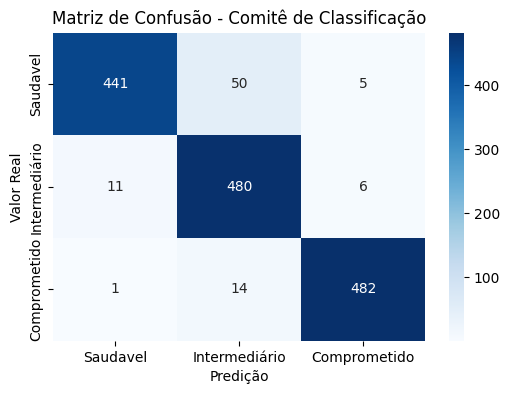

Relatório de Classificação do Comitê:
              precision    recall  f1-score   support

         1.0       0.97      0.89      0.93       496
         2.0       0.88      0.97      0.92       497
         3.0       0.98      0.97      0.97       497

    accuracy                           0.94      1490
   macro avg       0.94      0.94      0.94      1490
weighted avg       0.94      0.94      0.94      1490



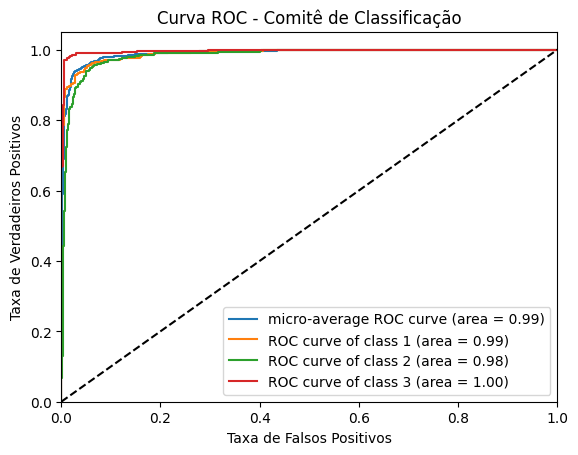

    Índice  Classe Esperada  Classe Predita
0     2183              2.0               2
1      610              1.0               1
2     3274              2.0               2
3     4682              3.0               3
4     3296              2.0               2
..     ...              ...             ...
95    4251              3.0               3
96    1784              1.0               1
97     141              1.0               1
98    2056              1.0               1
99    3818              3.0               2

[100 rows x 3 columns]


In [16]:
# usando Combinações Ponderadas por Probabilidade
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
from sklearn.preprocessing import label_binarize


# Função para calcular e exibir métricas de avaliação
def evaluate_model(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Use stratify
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else y_pred

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMétricas para {type(model).__name__}")
    print("Matriz de Confusão:")
    print(cm)

    # Relatório de Classificação
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # AUC-ROC
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

    # F1-score para a classe minoritária
    f1_minor_class = report.get("1", {}).get("f1-score", 0)  # Use get para acessar valores com segurança

    return roc_auc, f1_minor_class, model, X_test, y_test


# Carregar dados e verificar a distribuição original
data = pd.read_csv("fetal_health.csv")
target = 'fetal_health'

# Preparar variáveis independentes e dependentes
X = data.drop(target, axis=1)
y = data[target]

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(y_res.value_counts())

# Modelos a serem usados no comitê
models = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier(n_neighbors=5)]
results = {}

# Avaliar cada modelo e armazenar os resultados
for model in models:
    roc_auc, f1_score_minor, fitted_model, X_test, y_test = evaluate_model(X_res, y_res, model)
    results[type(model).__name__] = {
        "AUC-ROC": roc_auc,
        "F1-score Minor Class": f1_score_minor,
        "model": fitted_model
    }

# Calcular pesos com base no desempenho dos modelos
total_auc = sum(result["AUC-ROC"] for result in results.values())
for model_name in results:
    results[model_name]["weight"] = results[model_name]["AUC-ROC"] / total_auc

# Predições ponderadas
final_proba = np.zeros((len(y_test), 3))  # Inicializar matriz para 3 classes
for model_name, result in results.items():
    weight = result["weight"]
    model = result["model"]
    proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else np.zeros((len(X_test), 3))

    # Garantir que proba tenha 3 colunas
    if proba.shape[1] != 3:
        # Ajustar probabilidades para 3 classes (exemplo de Naive Bayes binário)
        proba_adjusted = np.zeros((len(proba), 3))
        proba_adjusted[:, 1] = proba[:, 0]  # Alocar probabilidade na classe 2
        proba_adjusted[:, 2] = 1 - proba[:, 0]  # Restante na classe 3
        proba = proba_adjusted

    final_proba += weight * proba

# Converter probabilidades finais em predições finais
final_pred = np.argmax(final_proba.reshape(-1, 3), axis=1) + 1

# Matriz de Confusão e Relatório de Classificação do Comitê
cm = confusion_matrix(y_test, final_pred)
print("\nMatriz de Confusão do Comitê de Classificação:")
print(cm)

# Gráfico da Matriz de Confusão do Comitê
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Saudavel", "Intermediário", 'Comprometido'], yticklabels=["Saudavel", "Intermediário", 'Comprometido'])
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão - Comitê de Classificação")
plt.show()

# Relatório de Classificação do Comitê
print("Relatório de Classificação do Comitê:")
print(classification_report(y_test, final_pred))

# Curva ROC para o Comitê de Classificação
# Binarizar a saída
y_test_bin = label_binarize(y_test, classes=[1, 2, 3]) # Converte y_test para formato binário para cada classe
n_classes = y_test_bin.shape[1] # Número de classes

# Calcular curva ROC e área ROC para cada classe
fpr = dict() # Dicionário para armazenar taxa de falsos positivos para cada classe
tpr = dict() # Dicionário para armazenar taxa de verdadeiros positivos para cada classe
roc_auc = dict() # Dicionário para armazenar área sob a curva ROC para cada classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_proba[:, i])  # Use final_proba[:, i]
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], final_proba[:, i])    # AUC para a classe i

# Calcular curva ROC e área ROC micro-média
# Curva ROC micro-média
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), final_proba.ravel())  # Para micro-average
roc_auc["micro"] = roc_auc_score(y_test_bin, final_proba, average="micro")

# Plotar curva ROC para uma classe específica ou micro-média
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})' # Plota curva ROC micro-média
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' # Plota curva ROC para cada classe
                                   ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--') # Plota linha diagonal tracejada
plt.xlim([0.0, 1.0]) # Define limites do eixo x
plt.ylim([0.0, 1.05]) # Define limites do eixo y
plt.xlabel("Taxa de Falsos Positivos") # Define rótulo do eixo x
plt.ylabel("Taxa de Verdadeiros Positivos") # Define rótulo do eixo y
plt.title("Curva ROC - Comitê de Classificação") # Define título do gráfico
plt.legend(loc="lower right") # Define localização da legenda
plt.show() # Exibe o gráfico


# Criar DataFrame com as classificações
classification_results = pd.DataFrame({
    "Índice": X_test.index,
    "Classe Esperada": y_test.values,
    "Classe Predita": final_pred
})

# Exibir as primeiras linhas dos resultados de classificação
print(classification_results.head(100))